The data in "calls.txt" is five-minute call volume for a large North American bank handled on weekdays between 7:00am and 9:05pm, beginning 3 March 2003 for 164 days.

# 1. Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import datetime,date, timedelta
from pylab import rcParams
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import scipy.stats
import pylab

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller,grangercausalitytests,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox


from arch import arch_model

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,month_plot,quarter_plot
from statsmodels.tools.eval_measures import mse,rmse,meanabs

from pmdarima import auto_arima

# 2. Data Preprocessing

In [2]:
raw_data = pd.read_csv("calls.txt")
df= raw_data.copy() 
df

,x
0,111
1,113
2,76
3,82
4,91
...,...
27711,64
27712,49
27713,54
27714,55


In [3]:
df.isnull().sum()

x    0
dtype: int64

In [4]:
daily = len(df) / 164

In [5]:
daily_total = df.groupby(df.index // daily).sum()
daily_total

,x
0.0,41257
1.0,34975
2.0,32039
3.0,30912
4.0,32695
...,...
159.0,34293
160.0,34056
161.0,29598
162.0,29410


In [6]:
dates = pd.date_range("2003-03-01",periods=164,freq="b")
daily_total.columns = ["dailycalls"]
daily_total.index = dates
daily_total

,dailycalls
2003-03-03,41257
2003-03-04,34975
2003-03-05,32039
2003-03-06,30912
2003-03-07,32695
...,...
2003-10-10,34293
2003-10-13,34056
2003-10-14,29598
2003-10-15,29410


# 3. Plotting Data

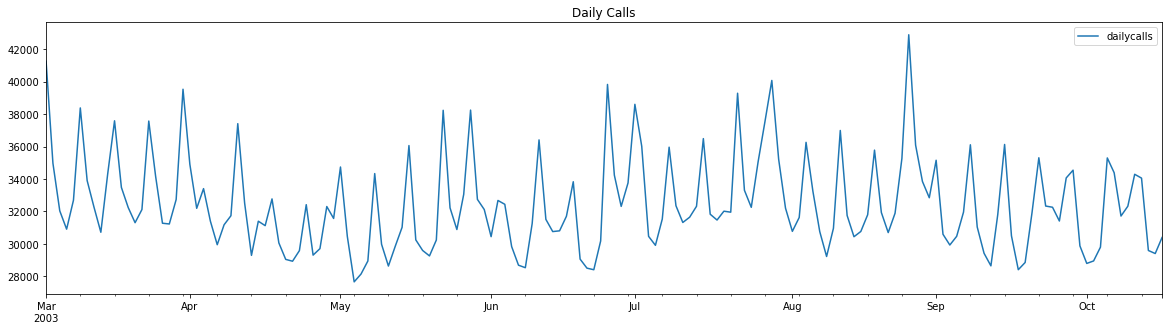

In [7]:
daily_total.plot(figsize=(20,5),title="Daily Calls");

**Closer look to check seasonal period:**

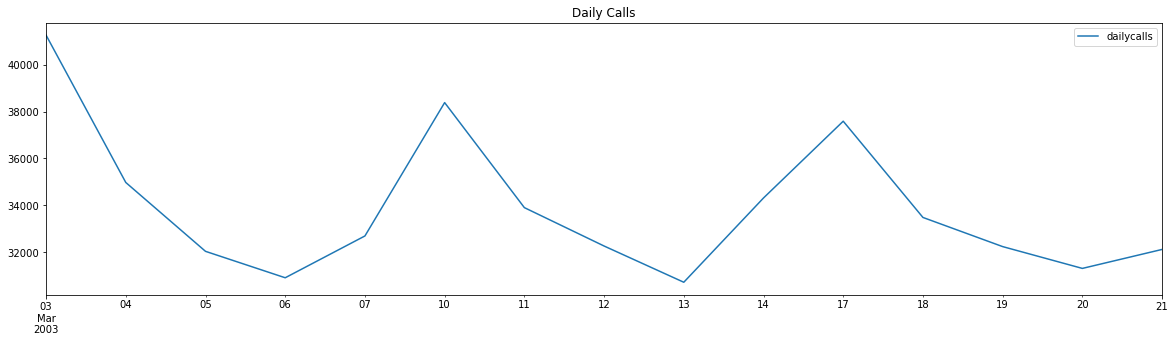

In [8]:
daily_total[:15].plot(figsize=(20,5),title="Daily Calls");

**A closer look reveals the seasonality. As can be seen, we can talk about a seasonality with weekly (5 working days in this case) periods.**

# 4. Train-Test Split

In [9]:
nobs = -5
df_train = daily_total[:nobs]
df_test = daily_total[nobs:]

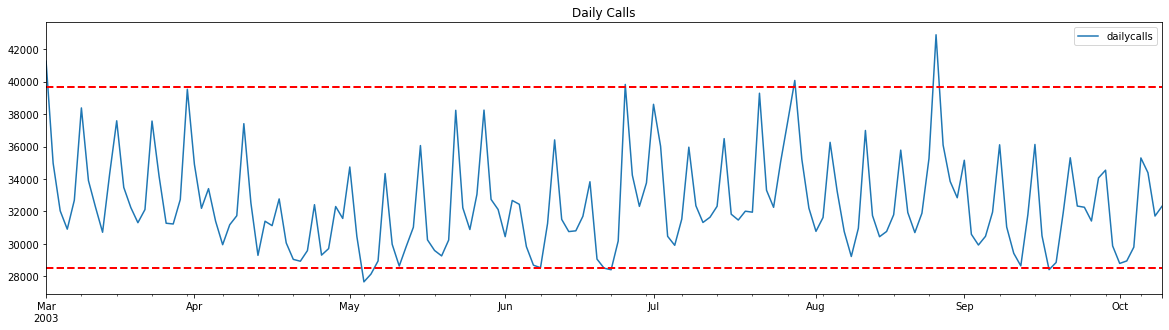

In [10]:
df_train.plot(figsize=(20,5),title="Daily Calls");
plt.axhline(y=39700, color='r', linestyle='--',lw=2)
plt.axhline(y=28500, color='r', linestyle='--',lw=2)

In [11]:
print(df_train.idxmax().item())
print(df_train.max().item())

2003-08-26 00:00:00
42889


In [12]:
print(df_train.idxmin().item())
print(df_train.min().item())

2003-05-05 00:00:00
27666


In [13]:
df_train.mean()

dailycalls    32489.962264
dtype: float64

**Observations:**

- It is seen that the maximum level was reached with 42.889 calls on 2003-08-26. After this peak, the numbers decreased.
- On 2003-05-05, the lowest level of calls was made with 27.666 calls, and then it rose again to above the average value of 32.490.
- It is observed that the number of calls generally fluctuates between 28.500 and 39.700, and only one or two violations occurred.
- It is observed that there is a seasonality due to the W structures formed by the call numbers over time and this seasonality is weekly (5 weekdays).

# 5. Seasonal Decompose

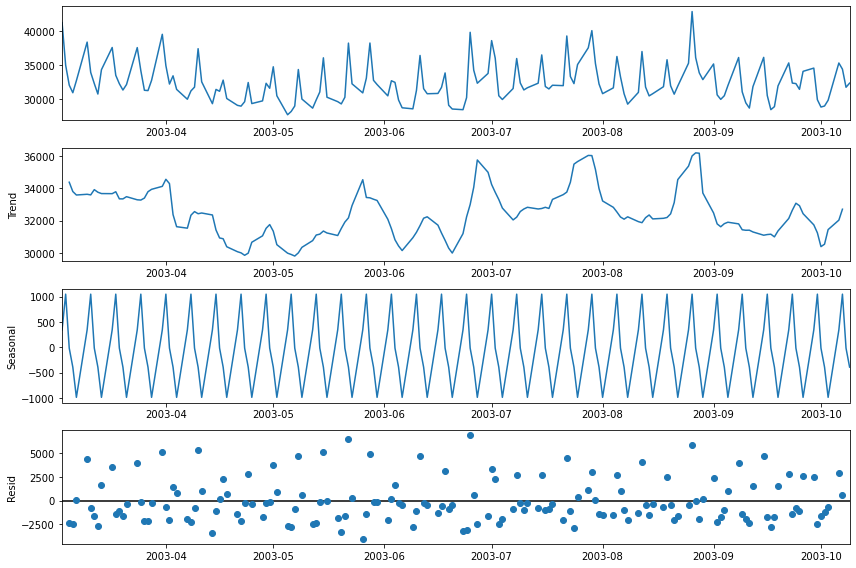

In [14]:
result = seasonal_decompose(df_train,model="add") 
rcParams["figure.figsize"] = 12,8
result.plot();

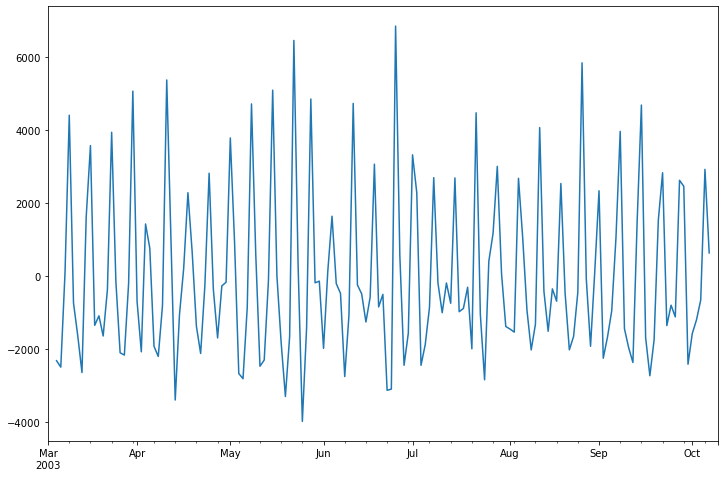

In [15]:
result.resid.plot();

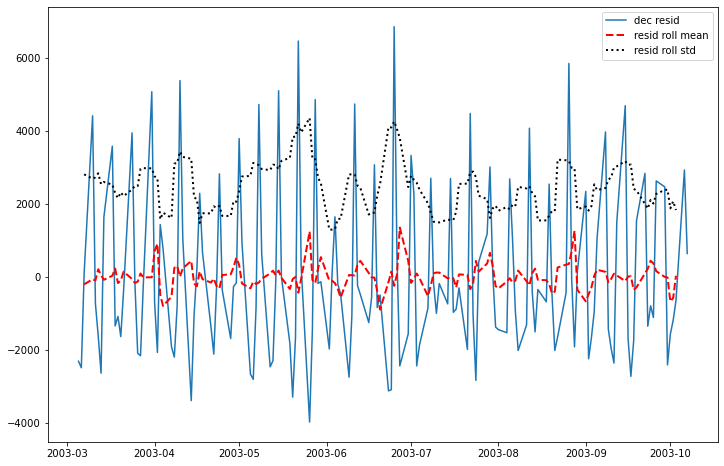

In [16]:
ar = result.resid
rolm = pd.Series.rolling(ar, window = 5, center = True).mean()
rolstd = pd.Series.rolling(ar, window = 5, center = True).std()
plt.plot(result.resid, label = 'dec resid')
plt.plot(rolm, label = 'resid roll mean', linestyle = '--',c="r",lw=2)
plt.plot(rolstd, label = 'resid roll std', linestyle = ':',c="black",lw=2)
plt.legend()
plt.show()

**In parallel with my previous observations, I see that there is seasonality. Apart from up and downs due to seasonality, we can say that residuals are also normally distributed and there is no trend in our time series.**

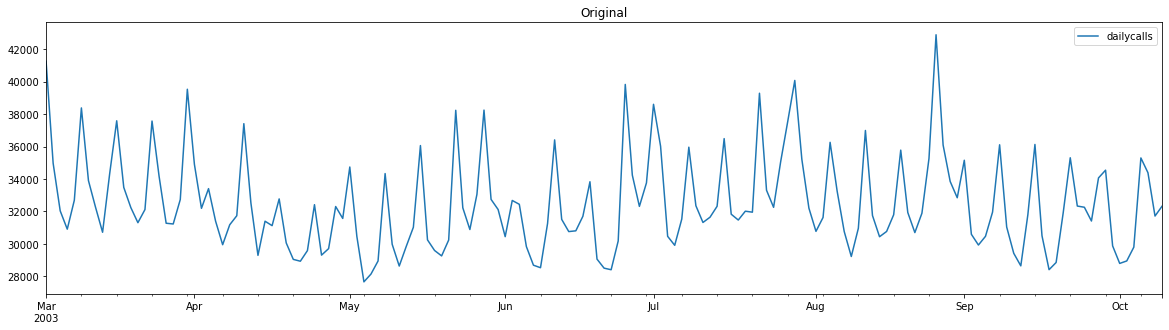

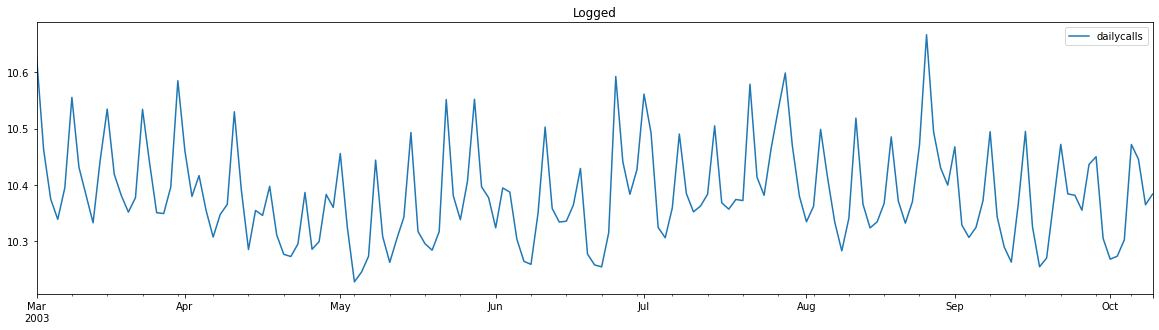

In [17]:
logged = np.log(df_train)

df_train.plot(figsize=(20,5),title="Original");
logged.plot(figsize=(20,5),title="Logged")
plt.show()

**As I can see no difference, I think log-transformation not needed.**

# 6. Original

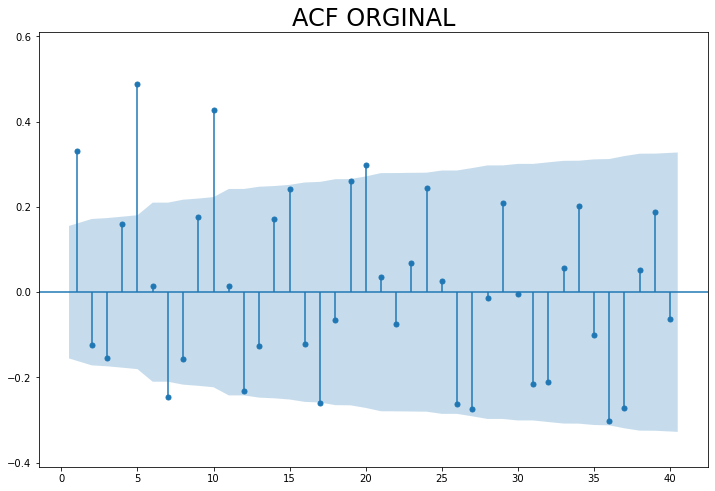

In [18]:
plot_acf(df_train,lags=40,zero=False,auto_ylims=True)
plt.title("ACF ORGINAL",size=24)
plt.show()

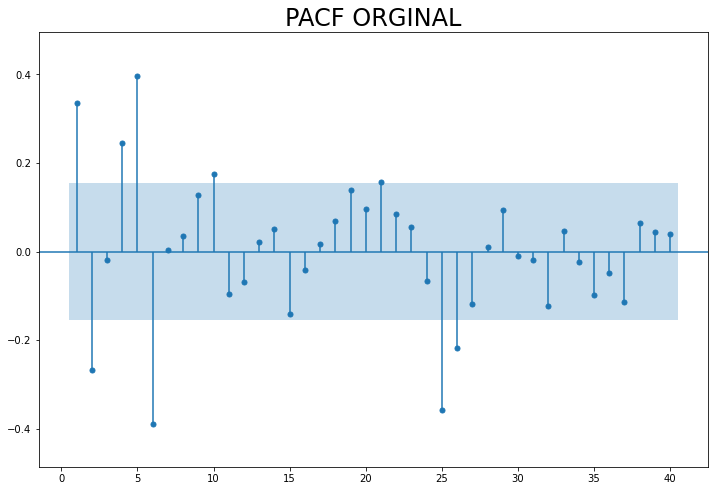

In [19]:
plot_pacf(df_train,lags=40,zero=False,auto_ylims=True)
plt.title("PACF ORGINAL",size=24)
plt.show()

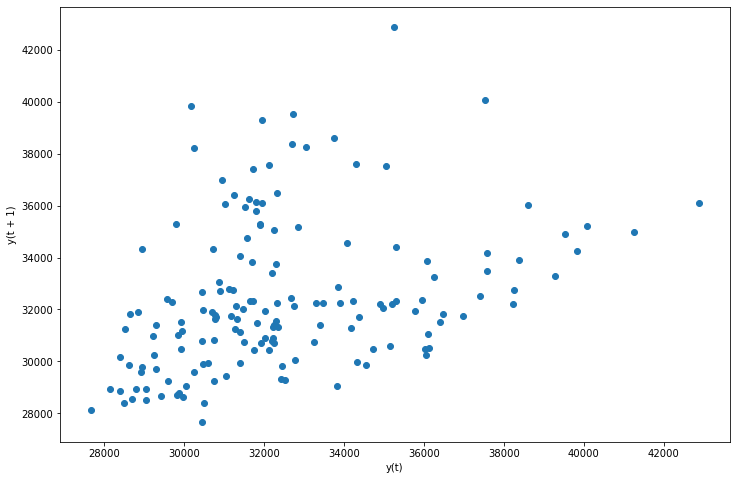

In [20]:
lag_plot(df_train);

**When I examine the original data with ACF and PACF plots, I see that there is a seasonality effect. While Lags 1, 5 and 10 draw my attention for ACF, lags numbered 1,2,4,5,6 are important for PACF.**

# 7. DIFF 1

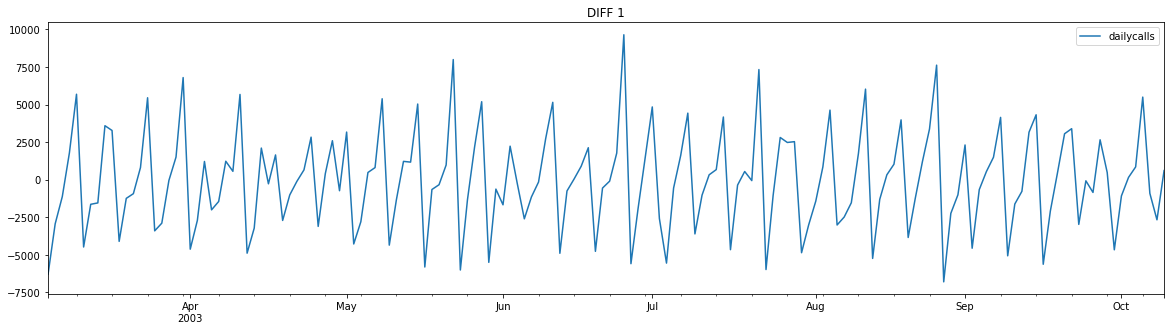

In [21]:
diff1 = diff(df_train,k_diff=1)
diff1.plot(figsize=(20,5),title="DIFF 1");

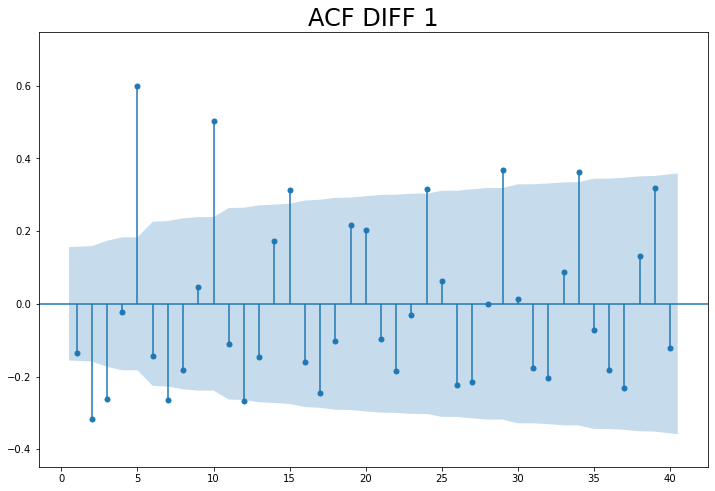

In [22]:
plot_acf(diff1,lags=40,zero=False,auto_ylims=True)
plt.title("ACF DIFF 1",size=24)
plt.show()

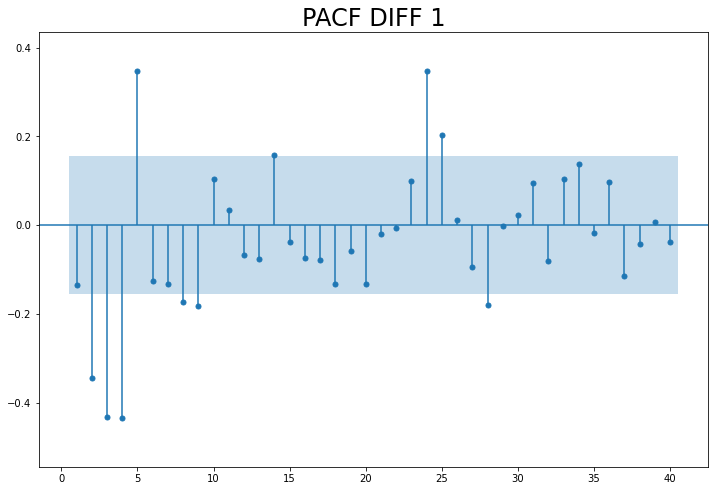

In [23]:
plot_pacf(diff1,lags=40,zero=False,auto_ylims=True)
plt.title("PACF DIFF 1",size=24)
plt.show()

**When we use the first differenciate function in our original data, we can see that the distribution looks more stationary, but the seasonality continues, and the volatility decreases at the same time. I observe that 2,3 and 5 lags are significant in ACF plot, while 2,3,4 and 5 lags are similar in PACF.**

# 8. SEASONAL DIFF 1

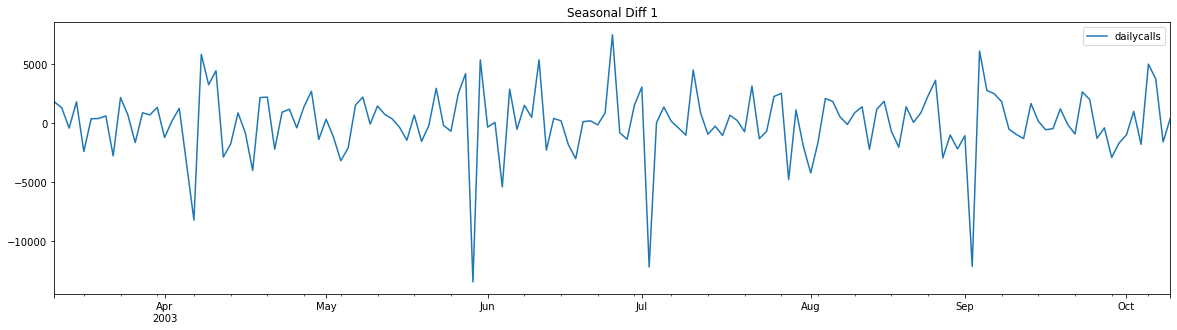

In [24]:
diff_s1 = diff(df_train,k_seasonal_diff=1,seasonal_periods=5)
diff_s1.plot(figsize=(20,5),title="Seasonal Diff 1");

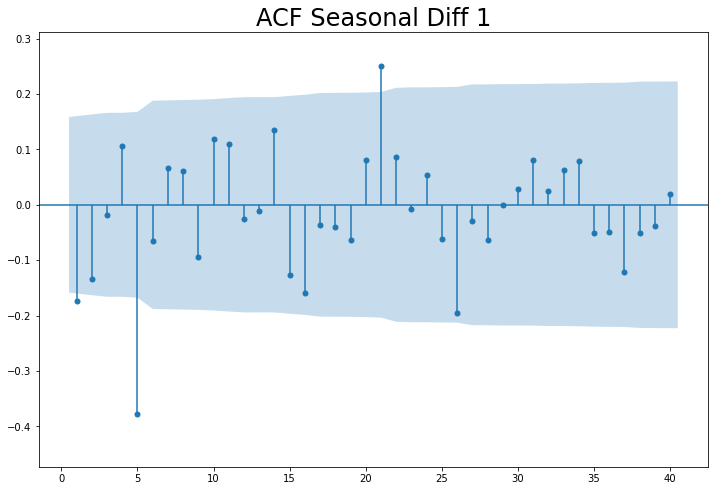

In [25]:
plot_acf(diff_s1,lags=40,zero=False,auto_ylims=True)
plt.title("ACF Seasonal Diff 1",size=24)
plt.show()

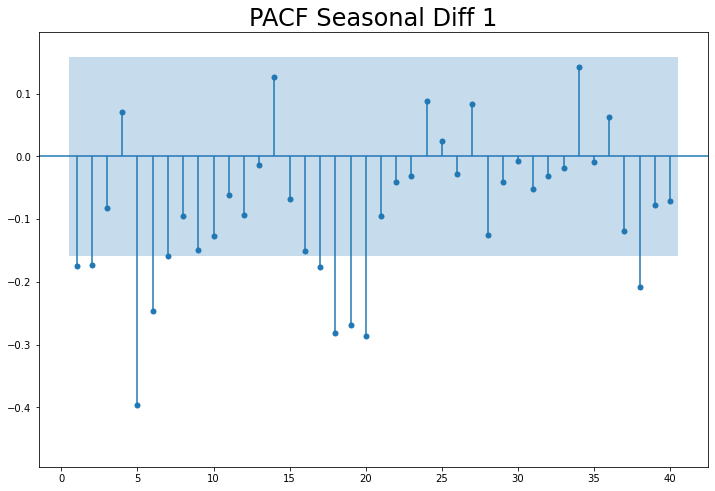

In [26]:
plot_pacf(diff_s1,lags=40,zero=False,auto_ylims=True)
plt.title("PACF Seasonal Diff 1",size=24)
plt.show()

**I am not satisfied with the volatility that occurred when we used seasonal differenciate. The lows, in particular, remained very distinctly low. The 5th lag in the ACF_PACF plots caught my attention.**

# 9. DIFF 1 + SEASONAL DIFF 1

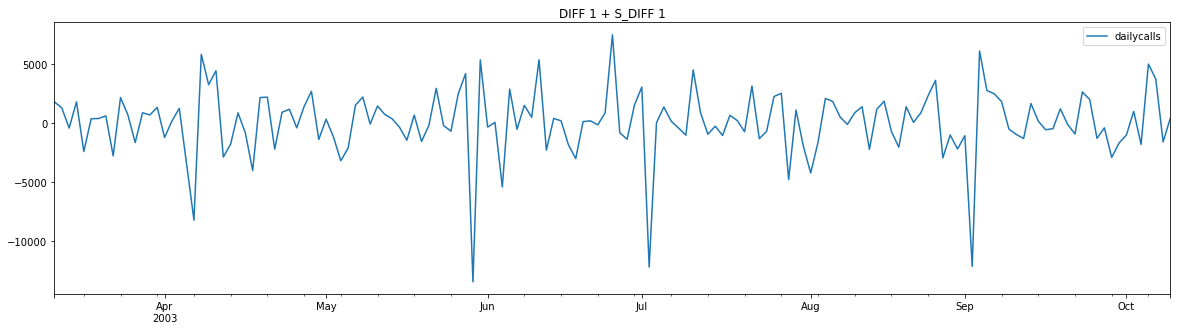

In [27]:
diffs = diff(df_train,k_diff=1,k_seasonal_diff=1,seasonal_periods=5)
diffs.plot(figsize=(20,5),title="DIFF 1 + S_DIFF 1");

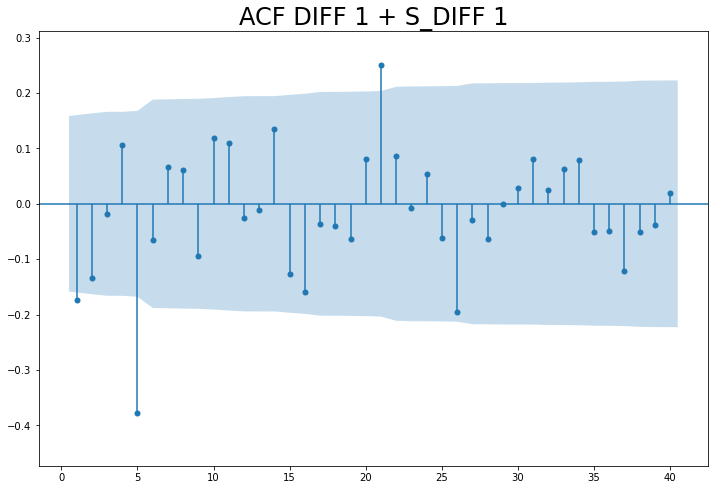

In [28]:
plot_acf(diffs,lags=40,zero=False,auto_ylims=True)
plt.title("ACF DIFF 1 + S_DIFF 1",size=24)
plt.show()

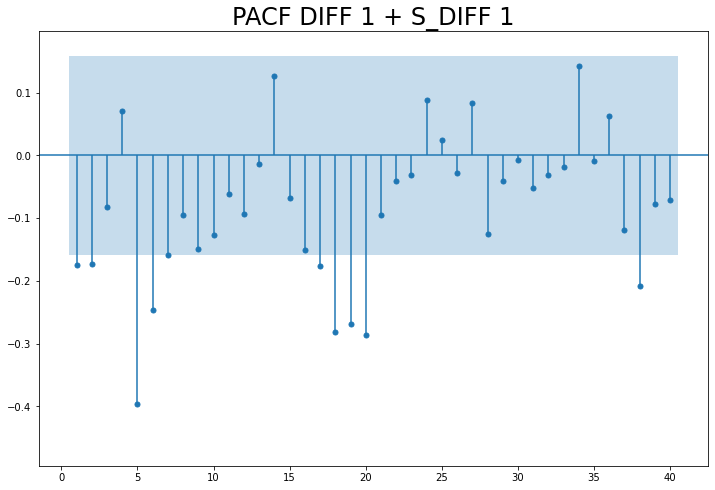

In [29]:
plot_pacf(diffs,lags=40,zero=False,auto_ylims=True)
plt.title("PACF DIFF 1 + S_DIFF 1",size=24)
plt.show()

**I encountered a similar situation that I mentioned above, when we added a normal diff to seasonal diff. The resulting volatility is too much and the results are similar.**

# 10. Dickey-Fuller/KPSS Tests For Stationarity + (Finding Diff)

In [30]:
def adf_kpss(series):
    results=[]
    adf_result = adfuller(series, autolag='AIC')
    kpss_result = kpss(series, regression='c', nlags="auto")
    if adf_result[1] <=0.05:
        adf_stationary = True
    else:
        adf_stationary = False
    if kpss_result[1] <=0.05:
        kpss_stationary = False
    else:
        kpss_stationary = True
        
    if adf_result[1] <=0.05 and kpss_result[1] > 0.05:
        stationary = "Stationary"
    elif adf_result[1] <=0.05 and kpss_result[1] <= 0.05:
        stationary = "Difference-stationary (difference series)"
    elif adf_result[1] > 0.05 and kpss_result[1] > 0.05:
        stationary = "Trend-stationary (de-trend series)"
    else:
        stationary = "Not stationary"
        
    results.append((adf_result[1], adf_stationary,kpss_result[1],kpss_stationary, stationary))
    results_df = pd.DataFrame(results, columns=['ADF P-value','ADF Stationary', 'KPSS P-value','KPSS Stationary','Result'])    
    return results_df

In [31]:
adf_kpss(df_train)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,ADF P-value,ADF Stationary,KPSS P-value,KPSS Stationary,Result
0,0.000193,True,0.1,True,Stationary


In [32]:
adf_kpss(diff1)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,ADF P-value,ADF Stationary,KPSS P-value,KPSS Stationary,Result
0,1.012477e-11,True,0.1,True,Stationary


In [33]:
adf_kpss(diff_s1)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,ADF P-value,ADF Stationary,KPSS P-value,KPSS Stationary,Result
0,2.740950e-10,True,0.1,True,Stationary


In [34]:
adf_kpss(diffs)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,ADF P-value,ADF Stationary,KPSS P-value,KPSS Stationary,Result
0,2.740950e-10,True,0.1,True,Stationary


In [35]:
def obtain_adf_kpss_results(timeseries, max_d):
    results=[]
    for idx in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags="auto")
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <=0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <=0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True            
        stationary = adf_stationary & kpss_stationary            
        results.append((idx,adf_result[1], kpss_result[1],adf_stationary,kpss_stationary, stationary))
    results_df = pd.DataFrame(results, columns=['Diff','ADF P-value','KPSS P-value', 'ADF Stationary','KPSS Stationary','RESULT' ])    
    return results_df

obtain_adf_kpss_results(df_train, 6)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,Diff,ADF P-value,KPSS P-value,ADF Stationary,KPSS Stationary,RESULT
0,0,1.926836e-04,0.1,True,True,True
1,1,1.012477e-11,0.1,True,True,True
2,2,3.632333e-11,0.1,True,True,True
3,3,9.655776e-13,0.1,True,True,True
4,4,1.373881e-12,0.1,True,True,True
5,5,4.225403e-13,0.1,True,True,True


**As seen in Dickey-Fuller and KPSS tests, all 4 series show stationarity.**

# 11. Model Trials with AutoArima

In [36]:
original = auto_arima(df_train,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2977.459, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2992.819, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2975.419, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2966.922, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3758.105, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2970.161, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2968.326, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2970.109, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.349 seconds


In [37]:
original.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1480.461
Date:                Thu, 02 Mar 2023   AIC                           2966.922
Time:                        01:34:30   BIC                           2976.128
Sample:                    03-03-2003   HQIC                          2970.660
                         - 10-09-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.237e+04    418.675     77.314      0.000    3.15e+04    3.32e+04
ma.L1          0.4789      0.095      5.066      0.000       0.294       0.664
sigma2      6.819e+06   8.24e+05      8.275      0.000     5.2e+06    8.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                36.43
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             1.09
Prob(H) (two-sided):                  0.93   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

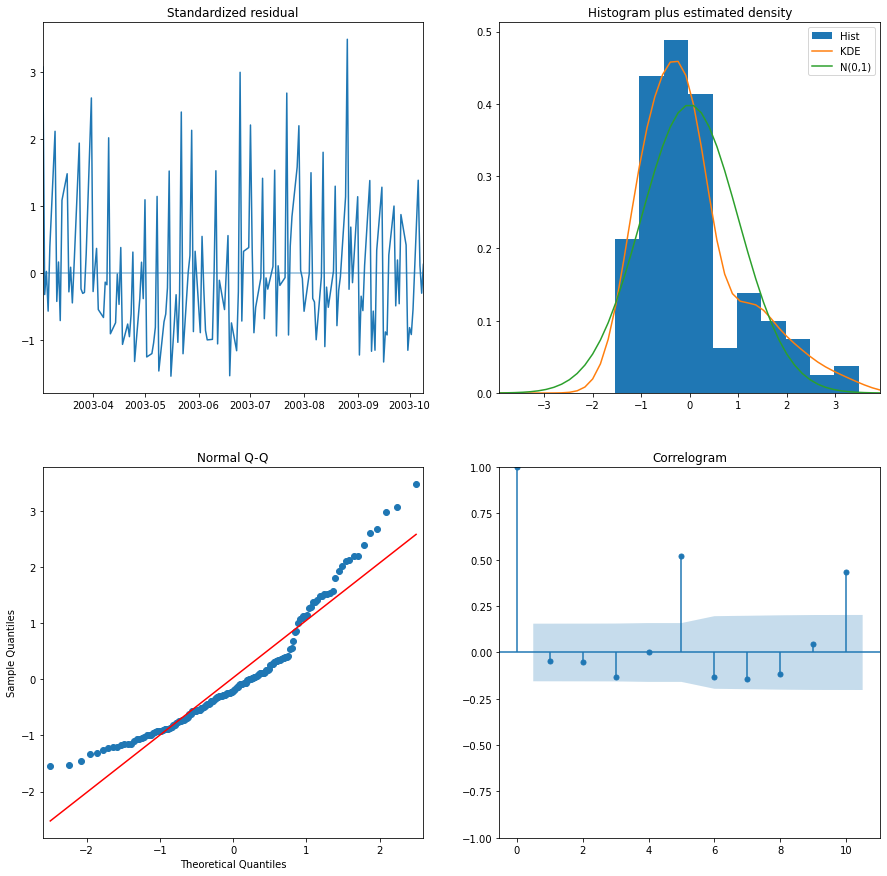

In [38]:
original.plot_diagnostics(figsize=(15,15))
plt.show()

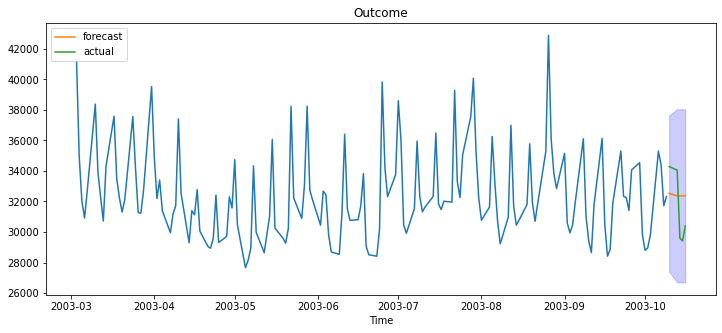

In [39]:
preds1, conf_int1 = original.predict(n_periods = df_test.shape[0], return_conf_int = True)

x_axis = df_test.index

plt.figure(figsize = (12,5))
plt.plot(df_train)
plt.plot(preds1, label = "forecast")  
plt.plot(df_test.dailycalls, label = "actual")  
plt.legend(loc="upper left")
plt.fill_between(x_axis[-preds1.shape[0]:], conf_int1[:, 0], conf_int1[:, 1], color='b', alpha = 0.2)
plt.title("Outcome")
plt.xlabel("Time")
plt.show()

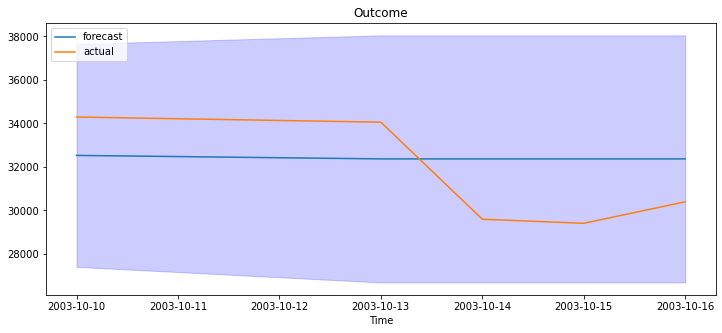

In [40]:
plt.figure(figsize = (12,5))
plt.plot(preds1, label = "forecast")  
plt.plot(df_test.dailycalls, label = "actual")  
plt.legend(loc="upper left")
plt.fill_between(x_axis[-preds1.shape[0]:], conf_int1[:, 0], conf_int1[:, 1], color='b', alpha = 0.2)
plt.title("Outcome")
plt.xlabel("Time")
plt.show()

**When we did an auto_arima for our original data without applying any normalization, ARMA process was created as we expected, and the appearance of the QQ plot and residuals is not normal.**

In [41]:
model_diff1 = auto_arima(df_train,d=1,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2961.319, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3013.832, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3009.365, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2993.666, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3011.881, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2941.405, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2962.519, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2937.688, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2938.056, Time=0.25 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2938.035, Time=0.37 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2930.599, Time=0.59 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2939.026, Time=0.75 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2

In [42]:
model_diff1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -1447.826
Date:                Thu, 02 Mar 2023   AIC                           2917.653
Time:                        01:34:46   BIC                           2951.341
Sample:                    03-03-2003   HQIC                          2931.334
                         - 10-09-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2945      0.186     -1.587      0.112      -0.658       0.069
ar.L2         -0.2966      0.106     -2.787      0.005      -0.505      -0.088
ar.L3         -0.3050      0.120     -2.536      0.011      -0.541      -0.069
ar.L4         -0.0981      0.124     -0.794      0.427      -0.340       0.144
ar.L5          0.5247      0.081      6.500      0.000       0.366       0.683
ma.L1         -0.1425      0.199     -0.716      0.474      -0.532       0.247
ma.L2         -0.0550      0.130     -0.422      0.673      -0.311       0.200
ma.L3         -0.0036      0.105     -0.034      0.973      -0.209       0.202
ma.L4         -0.2039      0.098     -2.075      0.038      -0.396      -0.011
ma.L5         -0.5214      0.139     -3.740      0.000      -0.795      -0.248
sigma2      4.962e+06   4.94e-08   1.01e+14      0.000    4.96e+06    4.96e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                17.49
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.65
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.36e+29. Standard errors may be unstable.
"""

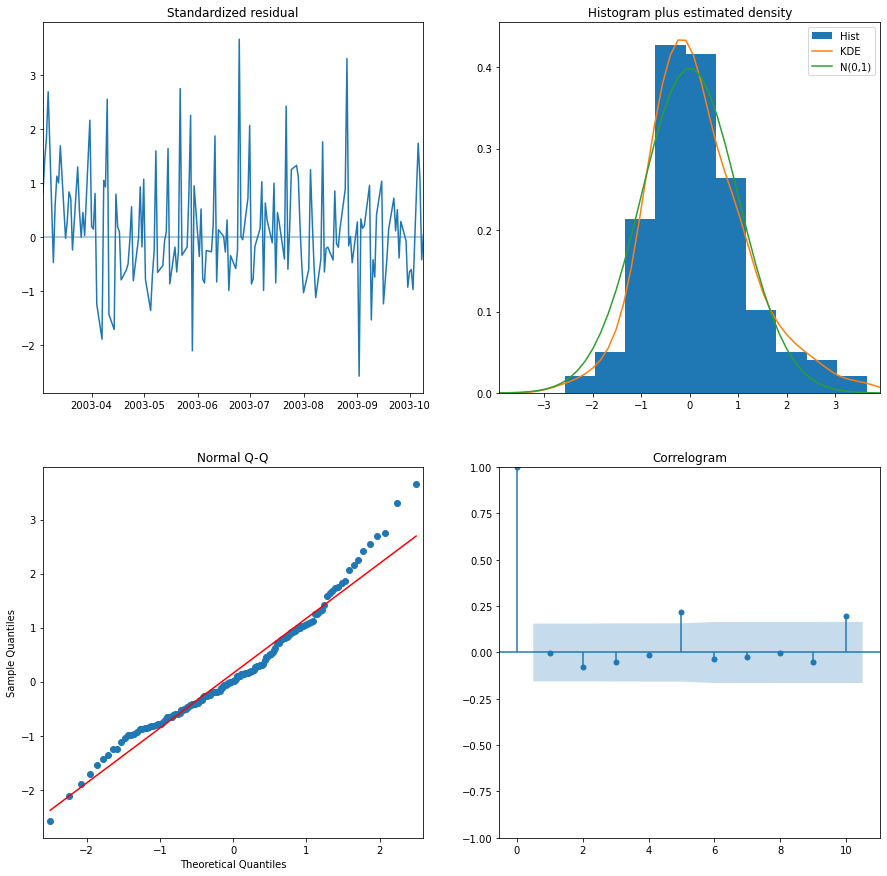

In [43]:
model_diff1.plot_diagnostics(figsize=(15,15))
plt.show()

**As we can see from the QQ plot of model that we performed by taking 1 diff, there is a better distribution compared to our original model, while the residuals are also partially better.**

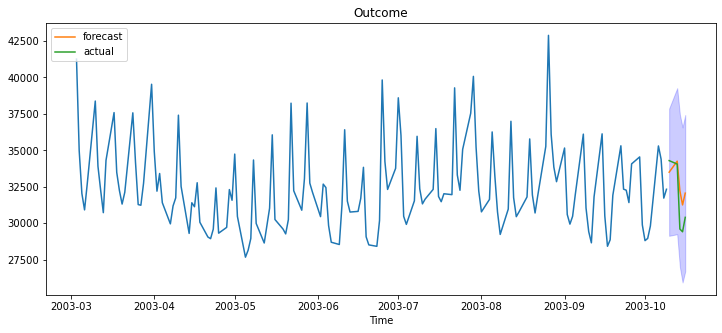

In [44]:
preds2, conf_int2 = model_diff1.predict(n_periods = df_test.shape[0], return_conf_int = True)

x_axis = df_test.index

plt.figure(figsize = (12,5))
plt.plot(df_train)
plt.plot(preds2, label = "forecast")  
plt.plot(df_test.dailycalls, label = "actual")  
plt.legend(loc="upper left")
plt.fill_between(x_axis[-preds2.shape[0]:], conf_int2[:, 0], conf_int2[:, 1], color='b', alpha = 0.2)
plt.title("Outcome")
plt.xlabel("Time")
plt.show()

In [45]:
model_seasonal_diff1 = auto_arima(df_train,D=1,
                          seasonal=True,m=5,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[5] intercept   : AIC=2863.123, Time=1.17 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=2895.106, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=2857.630, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=2860.914, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=2893.223, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=2878.833, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=2859.283, Time=0.41 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=2859.072, Time=0.21 sec
 ARIMA(1,0,0)(0,1,1)[5] intercept   : AIC=2857.228, Time=0.10 sec
 ARIMA(1,0,0)(0,1,2)[5] intercept   : AIC=2859.104, Time=0.18 sec
 ARIMA(1,0,0)(1,1,2)[5] intercept   : AIC=2857.773, Time=0.40 sec
 ARIMA(0,0,0)(0,1,1)[5] intercept   : AIC=2888.633, Time=0.09 sec
 ARIMA(2,0,0)(0,1,1)[5] intercept   : AIC=2859.265, Time=0.15 sec
 ARIMA(1,0,1)(0,1,1)[5] intercept   : AIC=2859.284, Time=0.19 sec
 ARIMA(2,0,1)(0,1,1)[5] intercept

In [46]:
model_seasonal_diff1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  159
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 5)   Log Likelihood               -1424.620
Date:                             Thu, 02 Mar 2023   AIC                           2855.240
Time:                                     01:34:53   BIC                           2864.351
Sample:                                 03-03-2003   HQIC                          2858.941
                                      - 10-09-2003                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3693      0.042      8.770      0.000       0.287       0.452
ma.S.L5       -0.2381      0.035     -6.756      0.000      -0.307      -0.169
sigma2      6.238e+06   4.51e+05     13.836      0.000    5.35e+06    7.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.71   Jarque-Bera (JB):                74.61
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.60
Prob(H) (two-sided):                  0.67   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

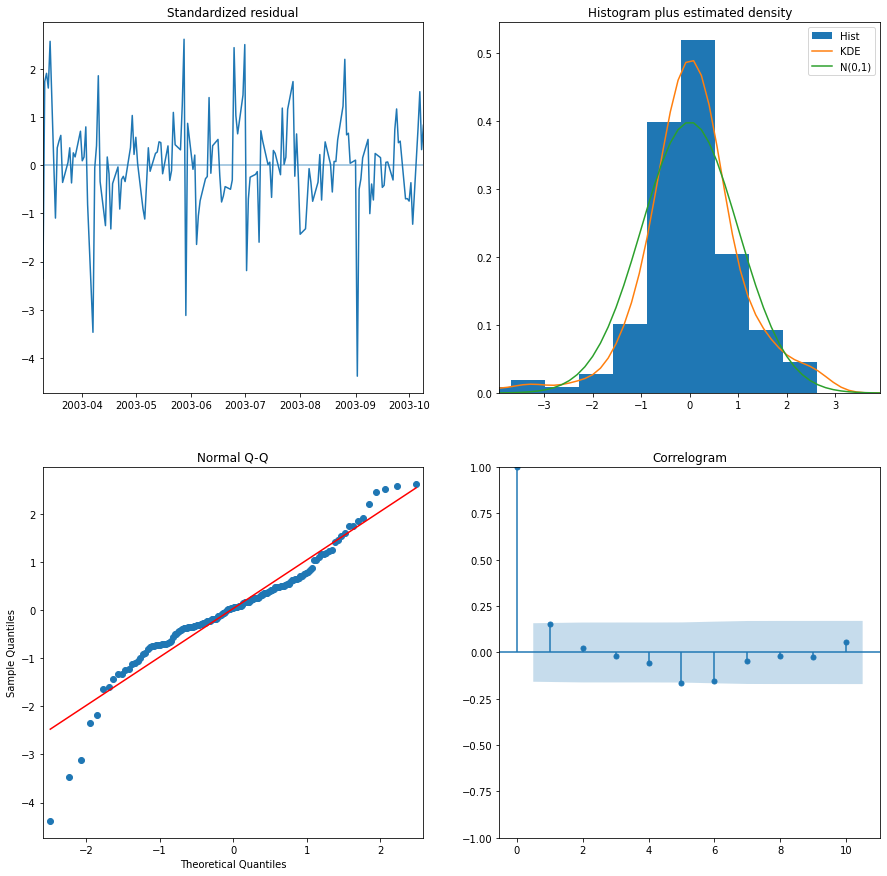

In [47]:
model_seasonal_diff1.plot_diagnostics(figsize=(15,15))
plt.show()

**As I commented on acf, pacf and line graph before about this model, the results did not satisfy me.**

In [48]:
model_diffs = auto_arima(df_train,d=1,D=1,
                          seasonal=True,m=5,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[5]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2873.765, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2863.021, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2858.249, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[5]             : AIC=2870.068, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[5]             : AIC=2859.043, Time=0.21 sec
 ARIMA(0,1,1)(0,1,2)[5]             : AIC=2859.031, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[5]             : AIC=2860.677, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[5]             : AIC=2861.000, Time=0.37 sec
 ARIMA(0,1,0)(0,1,1)[5]             : AIC=2862.269, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,2)(0,1,1)[5]             : AIC=2857.603, Time=0.12 sec
 ARIMA(0,1,2)(0,1,0)[5]             : AIC=2868.729, Time=0.08 sec
 ARIMA(0,1,2)(1,1,1)[5]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,2)(0,1,2)[5]             : AIC=2858.2

In [49]:
model_diffs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  159
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 5)   Log Likelihood               -1423.290
Date:                             Thu, 02 Mar 2023   AIC                           2856.581
Time:                                     01:35:06   BIC                           2871.733
Sample:                                 03-03-2003   HQIC                          2862.736
                                      - 10-09-2003                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8279      0.102      8.127      0.000       0.628       1.028
ma.L1         -1.0408      0.131     -7.947      0.000      -1.298      -0.784
ma.L2          0.0640      0.112      0.573      0.567      -0.155       0.283
ma.S.L5       -0.2201      0.062     -3.559      0.000      -0.341      -0.099
sigma2      7.893e+06   5.78e+05     13.651      0.000    6.76e+06    9.03e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):               200.42
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -1.37
Prob(H) (two-sided):                  0.73   Kurtosis:                         7.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

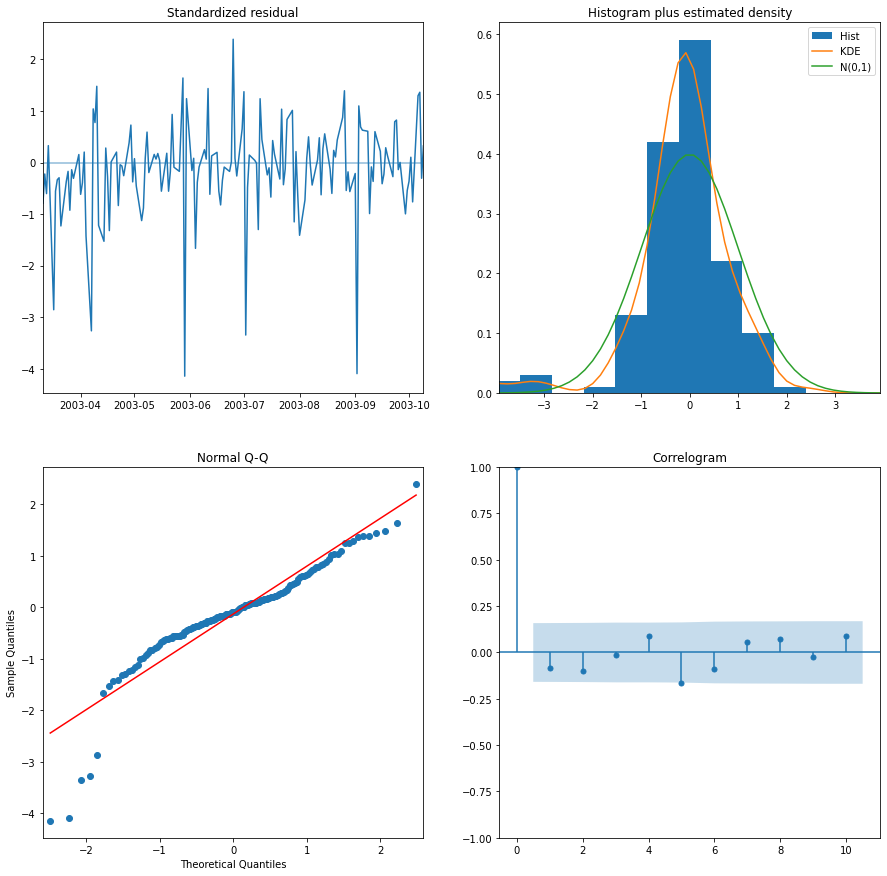

In [50]:
model_diffs.plot_diagnostics(figsize=(15,15))
plt.show()

**As I commented on acf, pacf and line graph before about this model, the results did not satisfy me.**

# 12. Predictions

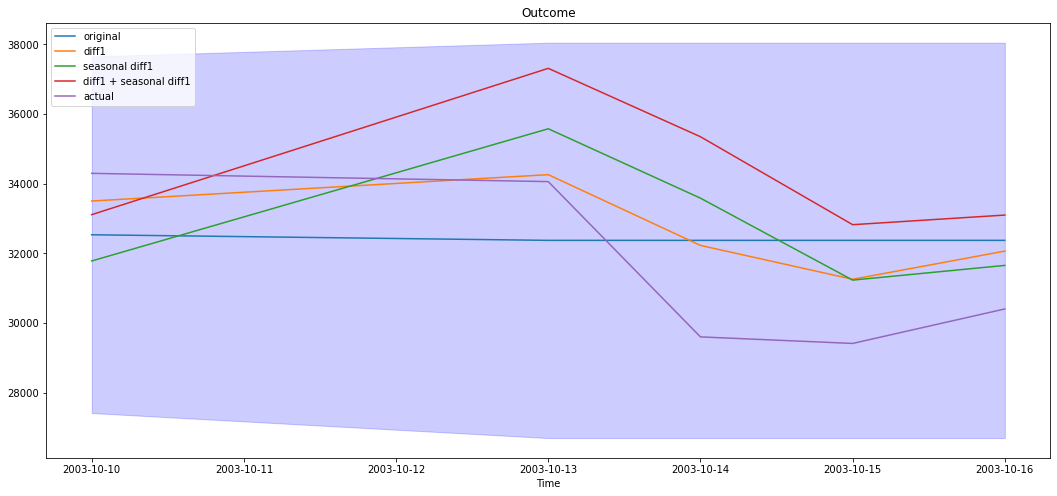

In [51]:
preds1, conf_int1 = original.predict(n_periods = df_test.shape[0], return_conf_int = True)
preds2, conf_int2 = model_diff1.predict(n_periods = df_test.shape[0], return_conf_int = True)
preds3, conf_int3 = model_seasonal_diff1.predict(n_periods = df_test.shape[0], return_conf_int = True)
preds4, conf_int4 = model_diffs.predict(n_periods = df_test.shape[0], return_conf_int = True)

plt.figure(figsize = (18,8))
plt.plot(preds1, label = "original")  
plt.plot(preds2, label = "diff1")  
plt.plot(preds3, label = "seasonal diff1")  
plt.plot(preds4, label = "diff1 + seasonal diff1")  
plt.plot(df_test.dailycalls, label = "actual")  
plt.legend(loc="upper left")
plt.fill_between(x_axis[-preds1.shape[0]:], conf_int1[:, 0], conf_int1[:, 1], color='b', alpha = 0.2)
plt.title("Outcome")
plt.xlabel("Time")
plt.show()

In [52]:
preds = pd.DataFrame(preds1)
preds.columns = ["Original"]

In [53]:
preds["Diff1"] = preds2
preds["SeasonalD1"] = preds3
preds["D1S1"] = preds4
preds["Test"] = df_test.dailycalls

preds

,Original,Diff1,SeasonalD1,D1S1,Test
2003-10-10,32529.918654,33498.335071,31777.823086,33107.567502,34293
2003-10-13,32369.266631,34255.313034,35573.053305,37307.445587,34056
2003-10-14,32369.266631,32224.139889,33580.766514,35344.083271,29598
2003-10-15,32369.266631,31251.747342,31228.251063,32819.125008,29410
2003-10-16,32369.266631,32060.931888,31650.129880,33095.313718,30400


In [54]:
print("RMSE Scores For Models:")
print("-------------------------")
print("Original                : ", round(rmse(preds.Test,preds.Original),2))
print("Diff 1                  : ", round(rmse(preds.Test,preds.Diff1),2))
print("Seasonal Diff 1         : ", round(rmse(preds.Test,preds.SeasonalD1),2))
print("Diff 1 + Seasonal Diff 1: ", round(rmse(preds.Test,preds.D1S1),2))

RMSE Scores For Models:
-------------------------
Original                :  2292.1
Diff 1                  :  1656.42
Seasonal Diff 1         :  2423.17
Diff 1 + Seasonal Diff 1:  3574.39


In [55]:
print("AIC Scores For Models:")
print("-------------------------")
print("Original                : ", original.aic())
print("Diff 1                  : ", model_diff1.aic())
print("Seasonal Diff 1         : ", model_seasonal_diff1.aic())
print("Diff 1 + Seasonal Diff 1: ", model_diffs.aic())

AIC Scores For Models:
-------------------------
Original                :  2966.9215671229595
Diff 1                  :  2917.6528850769855
Seasonal Diff 1         :  2855.2399414825477
Diff 1 + Seasonal Diff 1:  2856.5805511759777


### In this case, I prefer to choose the model named "model_diff1" with the best RMSE value. While making much closer estimations than others, there is not much difference between AIC values.

# For better results using rolling model:

In [56]:
rolling_predictions = []          
for train_end in df_test.index:
    train_data = daily_total[:train_end-timedelta(days=1)]
    model = ARIMA(train_data, order=(5,1,5))
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions.append(pred[0])
df_test["y"] = rolling_predictions

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [57]:
rolling_residuals = df_test.dailycalls - df_test.y
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1256.7125259942038


**There is a good improvement.**

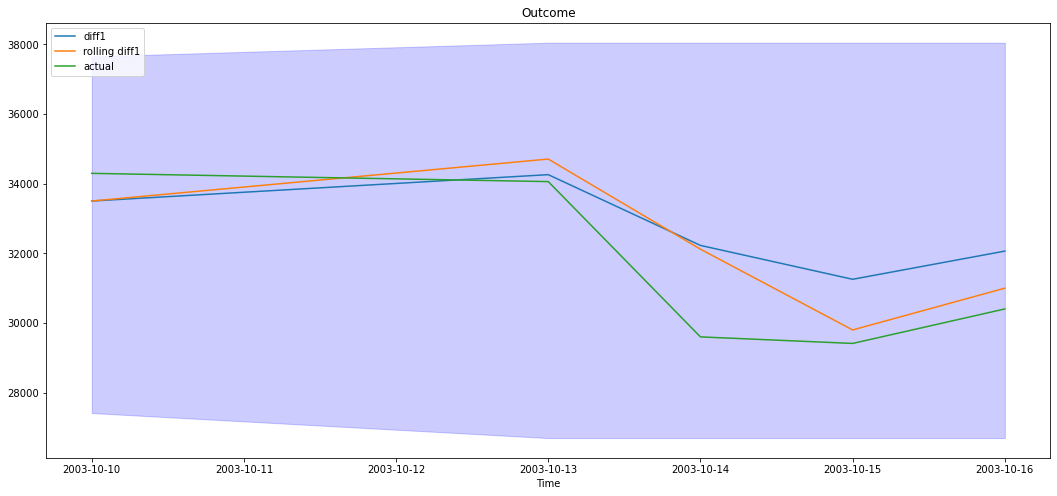

In [58]:
plt.figure(figsize = (18,8))
plt.plot(preds2, label = "diff1")  
plt.plot(df_test.y, label = "rolling diff1")  
plt.plot(df_test.dailycalls, label = "actual")  
plt.legend(loc="upper left")
plt.fill_between(x_axis[-preds1.shape[0]:], conf_int1[:, 0], conf_int1[:, 1], color='b', alpha = 0.2)
plt.title("Outcome")
plt.xlabel("Time")
plt.show()

In [59]:
model_diff1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -1447.826
Date:                Thu, 02 Mar 2023   AIC                           2917.653
Time:                        01:35:13   BIC                           2951.341
Sample:                    03-03-2003   HQIC                          2931.334
                         - 10-09-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2945      0.186     -1.587      0.112      -0.658       0.069
ar.L2         -0.2966      0.106     -2.787      0.005      -0.505      -0.088
ar.L3         -0.3050      0.120     -2.536      0.011      -0.541      -0.069
ar.L4         -0.0981      0.124     -0.794      0.427      -0.340       0.144
ar.L5          0.5247      0.081      6.500      0.000       0.366       0.683
ma.L1         -0.1425      0.199     -0.716      0.474      -0.532       0.247
ma.L2         -0.0550      0.130     -0.422      0.673      -0.311       0.200
ma.L3         -0.0036      0.105     -0.034      0.973      -0.209       0.202
ma.L4         -0.2039      0.098     -2.075      0.038      -0.396      -0.011
ma.L5         -0.5214      0.139     -3.740      0.000      -0.795      -0.248
sigma2      4.962e+06   4.94e-08   1.01e+14      0.000    4.96e+06    4.96e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                17.49
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.65
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.36e+29. Standard errors may be unstable.
"""

##### Equation:

𝑌𝑡=-0.2945𝑌𝑡−1-0.2966𝑌𝑡−2-0.3050𝑌𝑡−3-0.0981𝑌𝑡−4+0.5247𝑌𝑡−5+𝜖𝑡−0.1425𝜖𝑡−1-0.0550𝜖𝑡−2-0.0036𝜖𝑡−3-0.2039𝜖𝑡−4-0.5214𝜖𝑡−5